In [1]:
import cv2
import os
import numpy as np
import glob
import math
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
import imageio

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning


In [2]:
def generate_data(degree=None, 
                  scaling_factor=1, 
                  sd=.4,
                  random_state=42, 
                  mean=(2.5,0), 
                  N=1000):
    np.random.seed(random_state)
    
    sig_diff = np.array([3, 0])
    mean_a = np.array(mean) - sig_diff / 2
    mean_b = np.array(mean) + sig_diff / 2

    X_a = np.random.normal(mean_a, sd, size=(N // 2, 2))
    X_b = np.random.normal(mean_b, sd, size=(N // 2, 2))
    
    ## Add (rotated) distractor
    dir_noise = None
    if degree is not None:
        var_noise = .7
        e_a = np.random.normal(0, var_noise, N // 2).reshape(-1, 1)
        e_b = np.random.normal(0, var_noise, N // 2).reshape(-1, 1)
        r = degree * math.pi / 180
        dirX = math.sin(r)
        dirY = math.cos(r)
        dir_noise = np.array([dirX,dirY]).reshape(1, 2)
        noise_a = e_a * dir_noise
        X_a = X_a + noise_a
        noise_b = e_b * dir_noise
        X_b = X_b + noise_b
    
    # Scale x-axis
    X_a[:,0] *= scaling_factor
    X_b[:,0] *= scaling_factor
    return X_a, X_b, dir_noise

In [3]:
## CAV Functions
simplefilter("ignore", category=ConvergenceWarning)
simplefilter(action='ignore', category=FutureWarning)

def get_cav(X, y, cav_type, fit_intercept=True):
    if cav_type == "signal":
        mean_y = y.mean()
        X_residuals = X - X.mean(axis=0)[None]
        covar = (X_residuals * (y - mean_y)[:, np.newaxis]).sum(axis=0) / (y.shape[0] - 1)
        vary = np.sum((y - mean_y) ** 2, axis=0) / (y.shape[0] - 1)
        w = (covar / vary)
    else:
        if "svm" in cav_type:
            if "hard_margin" in cav_type:
                 linear = LinearSVC(random_state=0, fit_intercept=fit_intercept, max_iter=10000, C=1e10, penalty="l2", loss="hinge")
            else:
                linear = LinearSVC(random_state=0, fit_intercept=fit_intercept, max_iter=10000)
        elif "lasso" in cav_type:
            linear = Lasso(fit_intercept=fit_intercept)
        elif "ridge" in cav_type:
            linear = Ridge(fit_intercept=fit_intercept)
        elif "logistic" in cav_type:
            linear = LogisticRegression(fit_intercept=fit_intercept)
        else:
            raise ValueError(f"Unknown cav_type {cav_type}")
    
        linear.fit(X, y)
        w = linear.coef_.reshape(2,)
        
    w = w / np.linalg.norm(w)
    return w

In [4]:
## Plot function
def plot_cavs(X_a, X_b, ax, fit_intercept=True, overwrite_xaxis=True, cav_config=None, alpha=1.0, start_point_cavs=None):
    X, y = np.concatenate([X_a, X_b]), np.concatenate([np.zeros(len(X_a)), np.ones(len(X_b))])
    
    scatter_size = 15
    scale_vector = 5

    mean_a, mean_b = X_a.mean(axis=0), X_b.mean(axis=0)
    sns.scatterplot(x=X_a[:,0], y=X_a[:,1], c=['orange'], ax=ax, s=scatter_size, alpha=alpha)
    sns.scatterplot(x=X_b[:,0], y=X_b[:,1], c=['blue'], ax=ax, s=scatter_size, alpha=alpha)
    
    for cav_mode, c in cav_config.items():
        cav = get_cav(X, y, cav_mode, fit_intercept=fit_intercept)
        start_point = start_point_cavs or mean_a
        ax.quiver(start_point[0], start_point[1], *(cav), color=[c], scale_units='width', scale=scale_vector)
    
    if overwrite_xaxis:
        ax.set_xticks([mean_a[0], mean_b[0]])
        ax.set_xticklabels(('Non-Artifact', 'Artifact'))
    _ = plt.xlabel("concept direction")

    
    ax.legend(labels=["filter (SVM)", "pattern"], handles = [plt.plot([],ls="-")[0], plt.plot([],ls="-")[0]], ncols=2, bbox_to_anchor=(.89,-.05))
    leg = ax.get_legend()
    color_svm = cav_config["svm"] if "svm" in cav_config.keys() else cav_config["svm_hard_margin"]
    leg.legend_handles[0].set_color(color_svm)
    leg.legend_handles[0].set_alpha(1)
    leg.legend_handles[1].set_color(cav_config["signal"])
    leg.legend_handles[1].set_alpha(1)
    
    ax.set_xlabel("concept direction")
    ax.set_ylabel("other directions")
    
COLORS = [
          '#e94692ff', # pink
    '#52b791ff', # green
         ]

custom_palette = sns.color_palette(COLORS)
custom_palette

[(0.9137254901960784, 0.27450980392156865, 0.5725490196078431),
 (0.3215686274509804, 0.7176470588235294, 0.5686274509803921)]

In [5]:
## Functions to create video from images

def collect_imgs(path):
    img_array = []
    for filename in sorted(glob.glob(f"{path}/*"), key=lambda x: int(x[:-4].split("_")[-1])):
        img = cv2.imread(filename)
        img_array.append(img)
    
    height, width, layers = img_array[0].shape
    size = (width,height)      
    
    return img_array, size

def create_video(path, name, fps=10):
    
    imgs, size = collect_imgs(path)
    print(f"Creating video with {len(imgs)} images")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f"{name}.mp4", fourcc, fps, size)

    for i, img in enumerate(imgs):
        out.write(img)
    out.release()
    
    print("Video created.")

def bgr2rgb(img):
    return np.stack((img[:, :, 2], img[:, :, 1], img[:, :, 0]), axis=2)

def create_gif(path, name, fps=20):
    imgs, _ = collect_imgs(path)
    print(f"Creating GIF with {len(imgs)} images")
    imgs = [bgr2rgb(img) for img in imgs]
    imageio.mimwrite(f"{name}.gif", imgs, fps=fps)
    print("GIF created.")

In [6]:
cav_config = {
    "svm": COLORS[0],
    "signal": COLORS[1]
}

size = 4
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Noise Rotation

100%|██████████| 360/360 [01:24<00:00,  4.24it/s]


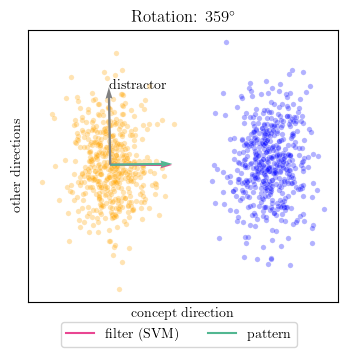

In [7]:
fit_intercept = True 
savepath = "_tmp/figs_noise_rotated"
os.makedirs(savepath, exist_ok=True)

degrees = range(0, 360)
# degrees = [0]

for i, degree in enumerate(tqdm.tqdm(degrees)):
    ncols, nrows = 1,1
    fig, axs = plt.subplots(nrows, ncols, figsize=(size*ncols,size*nrows), squeeze=False)
    ax = axs[0][0]
    
    
    X_a, X_b, dir_noise = generate_data(degree=degree)
    plot_cavs(X_a, X_b, ax, fit_intercept=fit_intercept, overwrite_xaxis=False, cav_config=cav_config, alpha=.3, start_point_cavs=None)
    ax.set_title(f"Rotation: {degree}" + "$^{\circ}$")
    ax.set_xticks([])
    ax.set_yticks([])
    
    ## Plot Distractor
    start_point = X_a.mean(0)
    ax.quiver(start_point[0], start_point[1], *(dir_noise[0]), color="grey", scale_units='width', scale=4)
    fontsize = 10
    ax.text(start_point[0] + dir_noise[0][0] * 1.7, 
            start_point[1] + dir_noise[0][1] * 1.7, 
            "distractor",
           fontsize=fontsize)
    fig.subplots_adjust(bottom=0.2)
    plt.savefig(f"{savepath}/degree_{degree}.png", dpi=300)
    if (i+1) < len(degrees):
        plt.close()

In [8]:
video_name = "video_noise_rotated"
create_video(savepath, video_name, fps=20)
create_gif(savepath, video_name, fps=20)

Creating video with 360 images
Video created.
Creating GIF with 360 images
GIF created.


## Feature Scaling

100%|██████████| 250/250 [01:19<00:00,  3.13it/s]


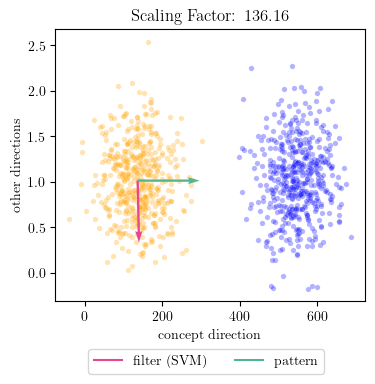

In [9]:
fit_intercept = True 
savepath = "_tmp/figs_scaled_axis"
os.makedirs(savepath, exist_ok=True)


scaling_factors = [1 * 1.025 ** i for i in range(-50, 200)]
# scaling_factors = [100]

for i, factor in enumerate(tqdm.tqdm(scaling_factors)):
    ncols, nrows = 1,1
    fig, axs = plt.subplots(nrows, ncols, figsize=(size*ncols,size*nrows), squeeze=False)
    ax = axs[0][0]
    X_a, X_b, _ = generate_data(scaling_factor=factor, mean=(2.5, 1))
    plot_cavs(X_a, X_b, ax, fit_intercept=fit_intercept, overwrite_xaxis=False, cav_config=cav_config, alpha=.3, start_point_cavs=None)
    ax.set_title(f"Scaling Factor: {factor:.2f}")
    
    ax.legend(handles = [plt.plot([],ls="-")[0], plt.plot([],ls="-")[0]], labels=["filter (SVM)", "pattern"], ncols=2, bbox_to_anchor=(.89,-.15))
    leg = ax.get_legend()
    color_svm = cav_config["svm"] if "svm" in cav_config.keys() else cav_config["svm_hard_margin"]
    leg.legend_handles[0].set_color(color_svm)
    leg.legend_handles[0].set_alpha(1)
    leg.legend_handles[1].set_color(cav_config["signal"])
    leg.legend_handles[1].set_alpha(1)
    fig.subplots_adjust(bottom=0.2)
    plt.savefig(f"{savepath}/factor_{i}.png", dpi=300)
    if (i+1) < len(scaling_factors):
        plt.close()

In [10]:
video_name = "video_scaled_axis"
create_video(savepath, video_name, fps=20)
create_gif(savepath, video_name, fps=20)

Creating video with 250 images
Video created.
Creating GIF with 250 images
GIF created.


## Random States

In [11]:
cav_config_random_state = {
    "svm_hard_margin": COLORS[0],
    "signal": COLORS[1]
}

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:13<00:00,  3.83it/s]


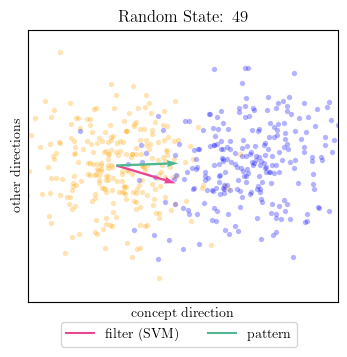

In [12]:
fit_intercept = True 
savepath = "_tmp/figs_random_states"
os.makedirs(savepath, exist_ok=True)


states = range(50)

for s in tqdm.tqdm(states):
    ncols, nrows = 1,1
    fig, axs = plt.subplots(nrows, ncols, figsize=(size*ncols,size*nrows), squeeze=False)
    ax = axs[0][0]
    X_a, X_b, _ = generate_data(mean=(2.5,0),
                             sd=1., 
                             random_state=s, 
                             N=500)
    
    
    
    plot_cavs(X_a, X_b, ax, fit_intercept=fit_intercept, overwrite_xaxis=False, 
              start_point_cavs=(1,0), cav_config=cav_config_random_state, alpha=.3)
    
    ax.set_xlim(-1,6)
    ax.set_ylim(-3.5, 3.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Random State: {s}")
    fig.subplots_adjust(bottom=0.2)
    plt.savefig(f"{savepath}/state_{s}.png", dpi=300)
    if (s+1) < len(states):
        plt.close()

In [13]:
video_name = "video_random_states"
create_video(savepath, video_name, fps=5)
create_gif(savepath, video_name, fps=5)

Creating video with 50 images
Video created.
Creating GIF with 50 images
GIF created.


## Increasing Standard Deviation

In [14]:
cav_config_sd = {
    "svm_hard_margin": COLORS[0],
    "signal": COLORS[1]
}

Testing standard deviations from 0.05 to 6.92


100%|██████████| 250/250 [01:20<00:00,  3.09it/s]


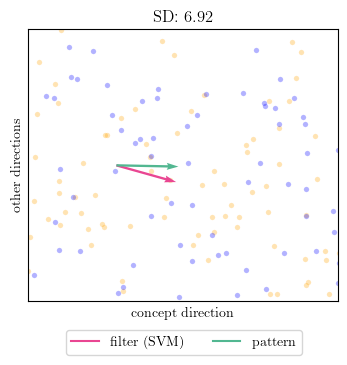

In [15]:
fit_intercept = True 
savepath = "_tmp/figs_increasing_sd"
os.makedirs(savepath, exist_ok=True)

sds = [0.05 * 1.02 ** p for p in range(250)]
print(f"Testing standard deviations from {min(sds):.2f} to {max(sds):.2f}")

for i, sd in enumerate(tqdm.tqdm(sds)):
    ncols, nrows = 1,1
    fig, axs = plt.subplots(nrows, ncols, figsize=(size*ncols,size*nrows), squeeze=False)
    ax = axs[0][0]
    X_a, X_b, _ = generate_data(mean=(2.5,0),
                             random_state=1,
                             sd=sd,
                             N=1000)
    
    
    plot_cavs(X_a, X_b, ax, fit_intercept=fit_intercept, overwrite_xaxis=False, 
              start_point_cavs=(1,0), cav_config=cav_config_sd, alpha=.3)
    
    ax.legend(handles = [plt.plot([],ls="-")[0], plt.plot([],ls="-")[0]], labels=["filter (SVM)", "pattern"], loc="upper left", ncols=2, bbox_to_anchor=(.1,-.08))
    leg = ax.get_legend()
    leg.legend_handles[0].set_color(cav_config_sd["svm_hard_margin"])
    leg.legend_handles[0].set_alpha(1)
    leg.legend_handles[1].set_color(cav_config_sd["signal"])
    leg.legend_handles[1].set_alpha(1)
    
    ax.set_xlim(-1,6)
    ax.set_ylim(-3.5, 3.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"SD: {sd:.2f}")
    fig.subplots_adjust(bottom=0.2)
    plt.savefig(f"{savepath}/sd_{i}.png", dpi=300)
    if (i+1) < len(sds):
        plt.close()

In [16]:
video_name = "video_increasing_sd"
create_video(savepath, video_name, fps=20)
create_gif(savepath, video_name, fps=20)

Creating video with 250 images
Video created.
Creating GIF with 250 images
GIF created.
